In [1]:
# =============================================================================================================
# Function: train experimental data, predict model data; or train model data, predict experimental data 
# The code reproduces Fig.3c,f,g,h.
# @Author: Yina Wei, 2021
#==============================================================================================================
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
from scipy import stats
from sklearn.utils import resample
from sankey import sankey
import ecp_func as ef # import self-written sub functions  
%matplotlib inline
import random

plt.rcParams.update({'font.size': 9})
sns.set_style("whitegrid", {'axes.grid' : False})
apsp_pal={0:[52/255.0,58/255.0,195/255.0],1:[220/255.0,53/255.0,57/255.0]}
cmap = sns.cubehelix_palette(light=1, as_cmap=True)

colorDict = {
    'FS':'steelblue',
    'RS':'crimson',
    'AP':[52/255.0,58/255.0,195/255.0],#'steelblue',
    'SP':[220/255.0,53/255.0,57/255.0],#'crimson',
}

cre_pal={    
    'Pvalb':'lightskyblue',
    'Sst':'thistle',
    'Nr5a1': 'peachpuff',
    'Rorb':  'khaki',
    'Scnn1a': 'lightcoral',#'#ffb3e6',
    'RS':'crimson',
    'FS':'steelblue'
}

In [2]:
# The setting of parameters 
random_num = 100  # The number of random_state for seperate the data into test and train data 
rep_num = 100     # The number of resampling 

## Load data

In [3]:
savefigdir = 'Figures/'
df_exp = pd.read_csv('data/exp_features.csv',index_col=0) # Load experimental data 
df_model = pd.read_csv('data/model_features.csv',index_col=0)  # Load Model data
#print(df_model.keys())

#Experimental features and cell types
one_ch_exp =  df_exp[['TPW','REP']].values
matrix_exp = df_exp[['PL_below','PL_above']].values
label_exp = np.array(df_exp['cell_type0'].values)
label2_exp = np.array(df_exp['cell_type'].values)
FS = np.where(label2_exp==0)[0]
RS = np.where(label2_exp==1)[0]

#Model features and cell types
one_ch_model =df_model[['TPW','REP']].values
matrix_model = df_model[['PL_below','PL_above']].values
cell_type = np.array(df_model['cell_type'].values)  # 0-Aspiny; 1-Spiny
SP=np.where(df_model['cell_type']==1)[0]
AP=np.where(df_model['cell_type']==0)[0]

# zscore plot of experimental data and model data

36
1846


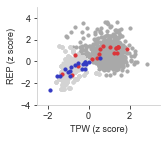

In [4]:
# Upsample minority class
SP_upsampled = resample(SP, 
                        replace=True,     # sample with replacement
                        n_samples=len(AP)-len(SP),    # to match majority class
                        random_state=27) # reproducible results

# Combine majority class with upsampled minority class
model_upsampled = np.concatenate([np.concatenate([SP, AP]),SP_upsampled])
print(len(model_upsampled))
X_model = stats.zscore(df_model[['TPW','REP']].iloc[model_upsampled].values)
Y_model = df_model['cell_type'].iloc[model_upsampled].values


# Upsample minority class
FS_upsampled = resample(FS, 
                        replace=True,     # sample with replacement
                        n_samples=len(RS)-len(FS),    # to match majority class
                        random_state=27) # reproducible results
# Combine majority class with upsampled minority class
exp_upsampled = np.concatenate([np.concatenate([RS, FS]),FS_upsampled])
print(len(exp_upsampled))
X_exp = stats.zscore(df_exp[['TPW','REP']].iloc[exp_upsampled].values)
Y_exp = df_exp['cell_type'].iloc[exp_upsampled].values



fig, ax = plt.subplots(figsize=(2.2,1.8))
ax=plt.subplot(111)
ax.scatter(X_exp[Y_exp==1, 0], X_exp[Y_exp==1, 1], color="darkgrey",s=10,label='RS')
ax.scatter(X_exp[Y_exp==0, 0], X_exp[Y_exp==0, 1], color="lightgrey",s=10,label='FS')
ax.scatter(X_model[Y_model==1, 0], X_model[Y_model==1, 1], color=[220/255.0,53/255.0,57/255.0],s=10,label='SP')
ax.scatter(X_model[Y_model==0, 0], X_model[Y_model==0, 1], color=[52/255.0,58/255.0,195/255.0],s=10,label='AP')
plt.xlabel('TPW (z score)')
plt.ylabel('REP (z score)')
plt.xlim(-2.5,3.5)
plt.ylim(-4,5)
ef.simpleaxis(ax)
#fig.savefig(savefigdir+'APSP_model_aa_EAP.pdf',bbox_inches = 'tight')
#fig.savefig(savefigdir+'APSP_model_aa_EAP.eps',bbox_inches = 'tight')

## Model based classifier

In [5]:
# The initilized parameters for model-based classifier
accuracy_XY_me = 0
conf_matrix_XY_me = np.array([[0, 0],[0, 0]])
w_me=[]
Coef_name_me=[]
y_exp_dictlist = [dict((j,0) for j in range(2)) for x in range(len(df_exp))]
random.seed(100)
for ii in range(rep_num):
    # Upsample minority class
    SP_upsampled = resample(SP, 
                            replace=True,       # sample with replacement
                            n_samples=len(AP)-len(SP),    # to match majority class
                            random_state=27+ii) # reproducible results
    # Combine majority class with upsampled minority class
    model_upsampled = np.concatenate([range(len(df_model)),SP_upsampled])
    #print(len(model_upsampled))
    X_model = stats.zscore(df_model[['TPW','REP']].iloc[model_upsampled].values)
    Y_model = df_model['cell_type'].iloc[model_upsampled].values


    # Upsample minority class
    FS_upsampled = resample(FS, 
                            replace=True,        # sample with replacement
                            n_samples=len(RS)-len(FS),    # to match majority class
                            random_state=27+ii)  # reproducible results
    # Combine majority class with upsampled minority class
    exp_upsampled = np.concatenate([range(len(df_exp)),FS_upsampled])
    #print(len(exp_upsampled))
    X_exp = stats.zscore(df_exp[['TPW','REP']].iloc[exp_upsampled].values)
    Y_exp = df_exp['cell_type'].iloc[exp_upsampled].values
    
    # Model-based classifier: Training model, predict exp
    accuracy_XY1,conf_matrix_XY1,accuracy_newXY1,conf_matrix_newXY1,w1,Coef_name1,dict_y_pred1=ef.classifier(X_model,Y_model,X_exp,Y_exp,'svm',random_num)
    accuracy_XY_me = accuracy_XY_me + accuracy_XY1
    conf_matrix_XY_me = conf_matrix_XY_me + conf_matrix_XY1
    w_me.append(w1)
    Coef_name_me.append(Coef_name1)
    for k in range(len(df_exp)):
        y_exp_dictlist[k][0]+=dict_y_pred1[k][0]
        y_exp_dictlist[k][1]+=dict_y_pred1[k][1]

The accuracy of test data set:81.67111111111099%


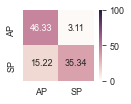

In [6]:
# Confusion Matrix
df_cm_XY = pd.DataFrame(conf_matrix_XY_me/rep_num, 
  index = [ 'AP', 'SP'],
  columns = ['AP', 'SP'])
print('The accuracy of test data set:'+str(accuracy_XY_me/rep_num*100)+'%')
fig, ax = plt.subplots(figsize=(1.8,1.3))
ax.set_aspect(1)
res = sns.heatmap(df_cm_XY, annot=True, vmin=0.0, vmax=100, fmt='.2f', cmap=cmap)

Text(0, 0.5, '${\\beta}$ Coeff')

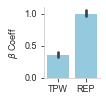

In [7]:
# Beta Coefficient
df=pd.DataFrame(np.mean(np.array(w_me),axis=0),columns=['Beta'])
df.insert(0, column="Coef_name",value = Coef_name1)
fig, ax = plt.subplots(figsize=(1.0,1.3))
ax = sns.barplot(x="Coef_name", y="Beta", data=df,color='skyblue')
ax.set_xticklabels(['TPW','REP'])
ef.simpleaxis(ax)
ax.set_xlabel('')                
ax.set_ylabel('${\\beta}$ Coeff')

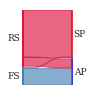

In [8]:
# Sankey plot 
cell_type_str=[]
for i in range(len(label2_exp)):
    cell_type_str.append('FS' if label2_exp[i]==0 else 'RS')

y_pred_str = []
for i in range(len(label2_exp)):
    d=y_exp_dictlist[i]
    maxoccur = max(d.items(), key=lambda x: x[1])[0]
    if maxoccur==0 and sum(d.values())!=0:
        y_pred_str.append('AP')
    elif maxoccur==1 and sum(d.values())!=0:    
        y_pred_str.append('SP')
    else:
        y_pred_str.append('Unsure')
df = pd.DataFrame(cell_type_str[::-1],columns=['cell_type'])
df.insert(0, column="label",value=y_pred_str[::-1])
fig=sankey(df['cell_type'],df['label'],fontsize=9,colorDict=colorDict,fig_size=(1.0,1.5))

## Experiment-based classifier

In [9]:
# The initilized parameters for experiment-based classifier
accuracy_XY_em = 0
conf_matrix_XY_em = np.array([[0, 0],[0, 0]])
w_em=[]
Coef_name_em=[]
y_model_dictlist = [dict((j,0) for j in range(2)) for x in range(len(df_model))]

random.seed(100)
for ii in range(rep_num):
    # Upsample minority class
    SP_upsampled = resample(SP, 
                            replace=True,       # sample with replacement
                            n_samples=len(AP)-len(SP),    # to match majority class
                            random_state=27+ii) # reproducible results
    # Combine majority class with upsampled minority class
    model_upsampled = np.concatenate([range(len(df_model)),SP_upsampled])
    #print(len(model_upsampled))
    X_model = stats.zscore(df_model[['TPW','REP']].iloc[model_upsampled].values)
    Y_model = df_model['cell_type'].iloc[model_upsampled].values


    # Upsample minority class
    FS_upsampled = resample(FS, 
                            replace=True,        # sample with replacement
                            n_samples=len(RS)-len(FS),    # to match majority class
                            random_state=27+ii)  # reproducible results
    # Combine majority class with upsampled minority class
    exp_upsampled = np.concatenate([range(len(df_exp)),FS_upsampled])
    #print(len(exp_upsampled))
    X_exp = stats.zscore(df_exp[['TPW','REP']].iloc[exp_upsampled].values)
    Y_exp = df_exp['cell_type'].iloc[exp_upsampled].values
    
    # Experiment-based classifier: Training exp, predict model
    accuracy_XY0,conf_matrix_XY0,accuracy_newXY0,conf_matrix_newXY0,w0,Coef_name0,dict_y_pred0=ef.classifier(X_exp,Y_exp,X_model,Y_model,'svm',random_num)
    accuracy_XY_em = accuracy_XY_em + accuracy_XY0
    conf_matrix_XY_em = conf_matrix_XY_em + conf_matrix_XY0 
    w_em.append(w0)
    Coef_name_em.append(Coef_name0)

    for k in range(len(df_model)):
        y_model_dictlist[k][0]+=dict_y_pred0[k][0]
        y_model_dictlist[k][1]+=dict_y_pred0[k][1]

The accuracy of test data set:99.62160173160166%


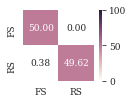

In [10]:
# Confusion Matrix
df_cm_XY = pd.DataFrame(conf_matrix_XY_em/rep_num, 
  index = [ 'FS', 'RS'],
  columns = ['FS', 'RS'])
print('The accuracy of test data set:'+str(accuracy_XY_em/rep_num*100)+'%')
fig, ax = plt.subplots(figsize=(1.8,1.3))
ax.set_aspect(1)
res = sns.heatmap(df_cm_XY, annot=True, vmin=0.0, vmax=100, fmt='.2f',cmap=cmap)

Text(0, 0.5, '${\\beta}$ Coeff')

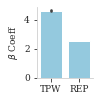

In [11]:
# Beta Coefficient 
df=pd.DataFrame(np.mean(np.array(w_em),axis=0),columns=['Beta'])
df.insert(0, column="Coef_name",value = Coef_name0)
fig, ax = plt.subplots(figsize=(1.0,1.3))
ax = sns.barplot(x="Coef_name", y="Beta", data=df,color='skyblue')
ax.set_xticklabels(['TPW','REP'])
ef.simpleaxis(ax)
ax.set_xlabel('')                
ax.set_ylabel('${\\beta}$ Coeff')

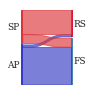

In [12]:
cell_type_str=[]
for i in range(len(df_model)):
    cell_type_str.append('AP' if Y_model[i]==0 else 'SP')

y_pred_str = []
for i in range(len(df_model)):
    d=y_model_dictlist[i]
    maxoccur = max(d.items(), key=lambda x: x[1])[0]
    if maxoccur==0:
        y_pred_str.append('FS')
    else:    
        y_pred_str.append('RS')
        
# Sankey plot mapping AP/SP to FS/RS        
df = pd.DataFrame(cell_type_str[::-1],columns=['cell_type'])  # [::-1] : reverse the array for plotting
df.insert(0, column="label",value=y_pred_str[::-1])
fig=sankey(df['cell_type'],df['label'],fontsize=9,colorDict=colorDict,fig_size=(1.0,1.5))

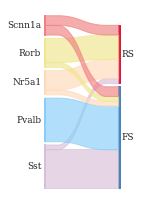

In [13]:
# Sankey plot mapping crelines to FS/RS
df = pd.DataFrame(df_model['cre_lines'].values[::-1],columns=['cell_type'])
df.insert(0, column="label",value=y_pred_str[::-1])
fig=sankey(df['cell_type'],df['label'],fontsize=9,fig_size=(1.5,3.5),colorDict=cre_pal)